CHANGED CODE

In [153]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


torch.utils.backcompat.broadcast_warning.enabled = True

# Dataset class
class EEGDataset:
    def __init__(self, eeg_signals_path):
        selected_EEG_data = torch.load(eeg_signals_path)
        Dataset_EEG = selected_EEG_data["sel_EEG_data"]
        self.all_images = selected_EEG_data["images"]
        self.data = Dataset_EEG['data']
        Labels = Dataset_EEG['labels']
        for idx in range(len(Labels)):
            Labels[idx] = 1 if Labels[idx] == 3 else 0
        self.labels = Labels
        self.images_num = Dataset_EEG['im_num']
        self.subject = Dataset_EEG['subject']
        self.size = len(self.data)

    def __len__(self):
        return self.size

    def __getitem__(self, i):
        eeg = self.data[i]
        label = self.labels[i]
        im_num = self.images_num[i]
        subject = self.subject[i]
        return eeg, label, im_num, subject


# Splitter class
class Splitter:
    def __init__(self, dataset, split_path, split_num=0, split_name="train"):
        self.dataset = dataset
        loaded = torch.load(split_path)
        self.split_idx = loaded["splits"][split_num][split_name]
        self.split_idx = [i for i in self.split_idx if 440 <= self.dataset.data[i].size(0) <= 600]
        self.size = len(self.split_idx)

    def __len__(self):
        return self.size

    def __getitem__(self, i):
        eeg, label, im_num, subject = self.dataset[self.split_idx[i]]
        return eeg, label, im_num, subject

In [154]:
class EEGNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.3):
        super(EEGNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        hn = hn[-1]
        hn = self.dropout(hn)
        out = self.fc(hn)
        return out


def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for signals, labels, _, _ in dataloader:
        signals, labels = signals.float().to(device), labels.long().to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(signals)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * signals.size(0)
        correct += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct.double() / total
    return epoch_loss, epoch_acc

def evaluate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for signals, labels, _, _ in dataloader:
            signals, labels = signals.float().to(device), labels.long().to(device)
            outputs = model(signals)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * signals.size(0)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct.double() / total
    return epoch_loss, epoch_acc

def fit_model(model, dataloaders, criterion, optimizer, num_epochs=10, device='cpu'):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_model_wts = None
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 40)

        train_loss, train_acc = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"Train Loss: {train_loss:.4f} ---> Train Accuracy: {train_acc:.4f}")

        val_loss, val_acc = evaluate_one_epoch(model, dataloaders['val'], criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Validation Loss: {val_loss:.4f} ---> Validation  Accuracy: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    plot_loss(train_losses, val_losses)
    plot_accuracy(train_accs, val_accs)
    return model



def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure()
    plt.plot(epochs, train_losses, label='Train Loss', color='blue') 
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')  
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()

def plot_accuracy(train_accs, val_accs):
    epochs = range(1, len(train_accs) + 1)
    plt.figure()
    plt.plot(epochs, train_accs, label='Train Accuracy', color='blue')  
    plt.plot(epochs, val_accs, label='Validation Accuracy', color='red') 
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


def print_model_details(model):
    total_params = 0
    print(f"{'Layer':<20}{'Parameters':<20}")
    print("-" * 40)
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            total_params += num_params
            print(f"{name:<20}{num_params:<20}")
    print("-" * 40)
    print(f"Total Trainable Parameters: {total_params}")

In [155]:
eeg_signals_path = 'Selected_2class_EEG_Dataset.pth'
splits_path = 'Selected_2class_split_by_image-1.pth'
split_num = 0
batch_size = 64
num_epochs = 50
input_size = 128
hidden_size = 64
num_classes = 2
learning_rate = 0.001

dataset = EEGDataset(eeg_signals_path)
EEG_loaders = {
    split: DataLoader(Splitter(dataset, split_path=splits_path, split_num=split_num, split_name=split),
                      batch_size=batch_size, drop_last=False, shuffle=True) for split in ["train", "val", "test"]}

model = EEGNet(input_size, hidden_size, num_classes, dropout_rate=0.5)
criterion = nn.CrossEntropyLoss()
print_model_details(model)


Layer               Parameters          
----------------------------------------
lstm.weight_ih_l0   32768               
lstm.weight_hh_l0   16384               
lstm.bias_ih_l0     256                 
lstm.bias_hh_l0     256                 
fc.weight           128                 
fc.bias             2                   
----------------------------------------
Total Trainable Parameters: 49794


/var/folders/ym/gjrx4mts0h3g9f_769wf3w8h0000gn/T/ipykernel_10909/1097702973.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  selected_EEG_data = torch.load(eeg_signals_p

In [156]:
from sklearn.metrics import accuracy_score, classification_report

def train_and_evaluate(model, dataloaders, criterion, optimizer, num_epochs, device, optimizer_name=""):
    print(f"\nTraining model with {optimizer_name} optimizer...")
    fitted_model = fit_model(model, dataloaders, criterion, optimizer, num_epochs, device)
    
    print(f"\nEvaluating model with {optimizer_name} optimizer...")
    y_true, y_pred = [], []
    model.eval()
    for signals, labels, _, _ in dataloaders['test']:
        signals, labels = signals.float().to(device), labels.long().to(device)
        with torch.no_grad():
            outputs = model(signals)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    test_accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    plot_confusion_matrix(y_true, y_pred)

    return fitted_model



Training model with Adam optimizer...

Epoch 1/50
----------------------------------------
Train Loss: 0.7036 ---> Train Accuracy: 0.5077
Validation Loss: 0.6718 ---> Validation  Accuracy: 0.5877

Epoch 2/50
----------------------------------------
Train Loss: 0.6453 ---> Train Accuracy: 0.6205
Validation Loss: 0.6432 ---> Validation  Accuracy: 0.6754

Epoch 3/50
----------------------------------------
Train Loss: 0.6181 ---> Train Accuracy: 0.6744
Validation Loss: 0.6295 ---> Validation  Accuracy: 0.6842

Epoch 4/50
----------------------------------------
Train Loss: 0.5831 ---> Train Accuracy: 0.7205
Validation Loss: 0.6095 ---> Validation  Accuracy: 0.7193

Epoch 5/50
----------------------------------------
Train Loss: 0.5570 ---> Train Accuracy: 0.7462
Validation Loss: 0.5863 ---> Validation  Accuracy: 0.7368

Epoch 6/50
----------------------------------------
Train Loss: 0.5374 ---> Train Accuracy: 0.7718
Validation Loss: 0.5579 ---> Validation  Accuracy: 0.7544

Epoch 7/50
-

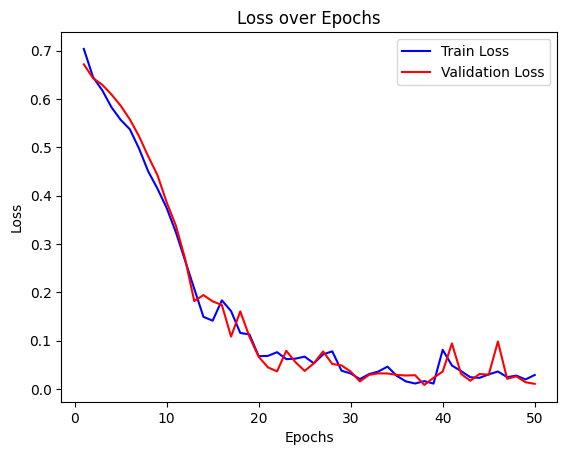

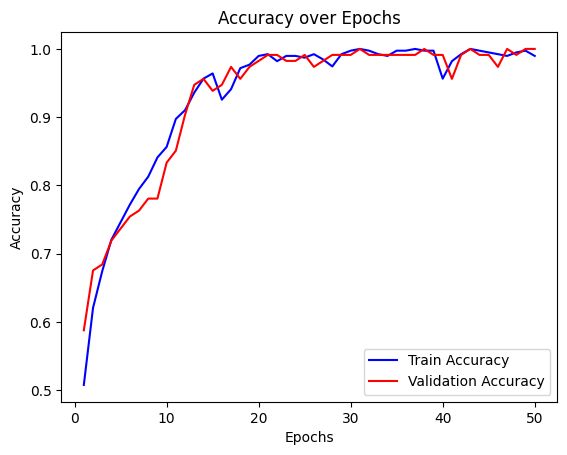


Evaluating model with Adam optimizer...
Test Accuracy: 0.9896


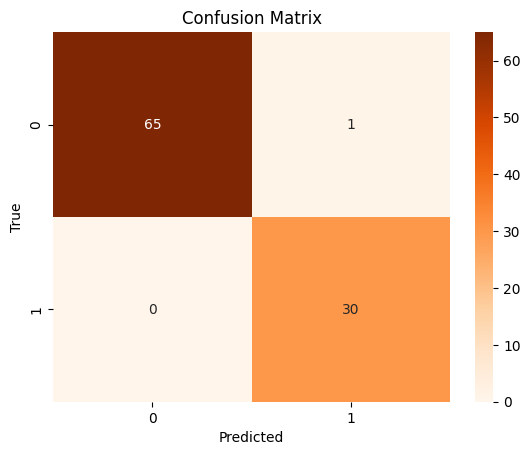

In [157]:
optimizer_Adam = optim.Adam(model.parameters(), lr=learning_rate)
trained_model_adam = train_and_evaluate(
    model, EEG_loaders, criterion, optimizer_Adam, num_epochs, device='cpu', optimizer_name="Adam"
)


Training model with SGD optimizer...

Epoch 1/50
----------------------------------------
Train Loss: 0.0112 ---> Train Accuracy: 1.0000
Validation Loss: 0.0107 ---> Validation  Accuracy: 1.0000

Epoch 2/50
----------------------------------------
Train Loss: 0.0101 ---> Train Accuracy: 1.0000
Validation Loss: 0.0107 ---> Validation  Accuracy: 1.0000

Epoch 3/50
----------------------------------------
Train Loss: 0.0116 ---> Train Accuracy: 1.0000
Validation Loss: 0.0107 ---> Validation  Accuracy: 1.0000

Epoch 4/50
----------------------------------------
Train Loss: 0.0099 ---> Train Accuracy: 1.0000
Validation Loss: 0.0106 ---> Validation  Accuracy: 1.0000

Epoch 5/50
----------------------------------------
Train Loss: 0.0104 ---> Train Accuracy: 1.0000
Validation Loss: 0.0106 ---> Validation  Accuracy: 1.0000

Epoch 6/50
----------------------------------------
Train Loss: 0.0111 ---> Train Accuracy: 1.0000
Validation Loss: 0.0106 ---> Validation  Accuracy: 1.0000

Epoch 7/50
--

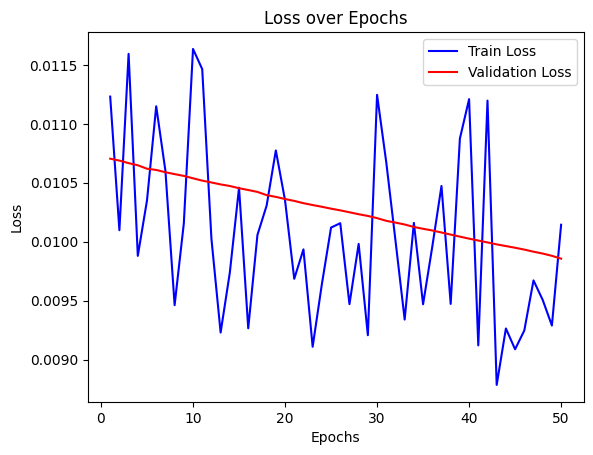

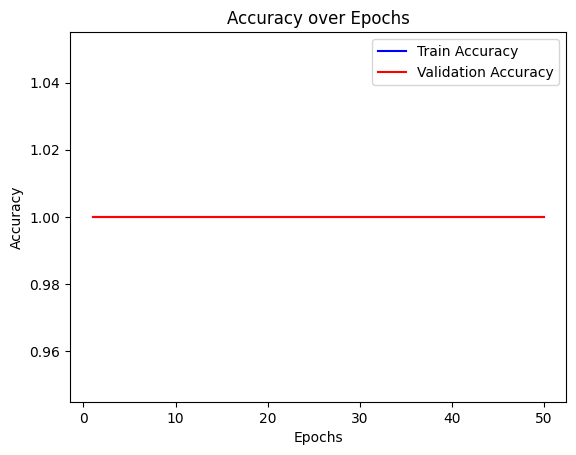


Evaluating model with SGD optimizer...
Test Accuracy: 0.9896


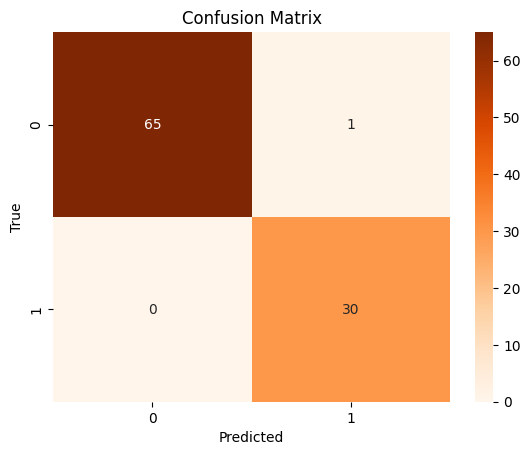

In [158]:
optimizer_SGD = optim.SGD(model.parameters(), lr=learning_rate)
trained_model_sgd = train_and_evaluate(
    model, EEG_loaders, criterion, optimizer_SGD, num_epochs, device='cpu', optimizer_name="SGD"
)